<a href="https://colab.research.google.com/github/CuriousKomodo/DL_assignment/blob/master/Past_Future_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras import callbacks, layers, losses, models, optimizers
from keras import backend as K
#from visualise import *
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM,CuDNNLSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout

dataset_path= '/content/drive/My Drive/Dataset/'
import theano


Using TensorFlow backend.


In [2]:
from keras import backend as K
K.clear_session()

W0704 17:58:28.644597 140437989459840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0704 17:58:28.650498 140437989459840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 17:58:28.688207 140437989459840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Create Validation Set

In [0]:
'''
X_train = np.load(dataset_path + 'PKUMMD/X_train.npy')
Y_train = np.load(dataset_path + 'PKUMMD/y_train.npy')
X_val= np.load(dataset_path + 'PKUMMD/X_test.npy')
Y_val = np.load(dataset_path + 'PKUMMD/y_val.npy')

X = np.concatenate([X_train,X_val],axis=0)
Y = np.concatenate([X_train,X_val],axis=0)
'''

In [0]:

import numpy as np
from sklearn.model_selection import train_test_split
#MAYBE GET VALIDATION SET AS WELL FROM THE CURRENT TRAINING SET. 
#X = np.load(dataset_path + 'PKUMMD/X_train.npy')
#Y = np.load(dataset_path + 'PKUMMD/y_train.npy')
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
np.save(dataset_path + 'PKUMMD/X_train.npy',X_train)
np.save(dataset_path + 'PKUMMD/X_val.npy',X_val)
np.save(dataset_path + 'PKUMMD/y_train.npy',y_train)
np.save(dataset_path + 'PKUMMD/y_val.npy',y_val)


# Scrap model

In [0]:

class Past_DataGenerator(keras.utils.Sequence):

    def __init__(self,
                 train_data_dir=dataset_path + 'PKUMMD/X_train.npy',
                 valid_data_dir=dataset_path + 'PKUMMD/X_val.npy',
                 train=True,
                 win_size=300,
                 step_size=2,
                 batch_size=128,
                 shuffle=True,
                 **kwargs):
      
        self.train_data_dir = train_data_dir
        self.valid_data_dir = valid_data_dir
        self.win_size = win_size
        self.step_size = step_size
        self.train=train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_list = self.load_data()
        self.on_epoch_end()

    def __len__(self):
        return int(len(self.data_list) / self.batch_size)

    def __getitem__(self, idx):
        if self.train:
          data = self.data_list[idx * self.batch_size:(idx + 1) * self.batch_size] #load by batch.
        else:
          data = self.data_list
        X = np.asarray(data, dtype=np.float32)
        Y = np.flip(X, axis=1)
        return X, Y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data_list)

    def load_data(self):
        '''
        data_list = []
        for f in os.listdir(self.data_dir):
            path = os.path.join(self.data_dir, f)
            data = np.load(path)
            size = int((len(data) - self.win_size) / self.step_size) + 1
            for i in range(size):
                data_list.append(data[self.step_size * i:self.step_size * i + self.win_size])
                '''
        if self.train:
          data_list = np.load(self.train_data_dir)
        else:
          data_list = np.load(self.valid_data_dir)
        return data_list


class LSTMAE(object):

    def __init__(self, dim=75, hidden_units=256):
        self.dim = dim
        self.hidden_units = hidden_units
        self.model = self.build()

    def build(self):
        inputs = layers.Input(shape=(None, self.dim))

        encoder = layers.CuDNNLSTM(self.hidden_units, return_state=True)
        decoder = layers.CuDNNLSTM(self.hidden_units, return_sequences=True, go_backwards=True)

        en_out, en_h, en_c = encoder(inputs)

        en_out = layers.Lambda(lambda x: x[:, None, :])(en_out)

        de_in = layers.Lambda(lambda x: x[:, 1:, :])(inputs) 

        de_outs = decoder(de_in, initial_state=[en_h, en_c])

        output = layers.concatenate([en_out, de_outs], 1)

        out_linear = layers.TimeDistributed(layers.Dense(self.dim))
        out = out_linear(output)

        return models.Model(inputs, out)

    def train(self):
        params_train = {
      'lr': 0.0005,'batch_size': 256, 'epochs': 30,'win_size': 600,'train':True}
        
        params_valid = {
      'lr': 0.0005,'batch_size': 256, 'epochs': 30,'win_size': 600,'train':False}

        self.model.compile(optimizer=optimizers.Adam(lr=params['lr']),
                           loss=losses.mean_squared_error)
        self.model.fit_generator(generator=DataGenerator(**params_train),
                                 epochs=params['epochs'],validation_data = DataGenerator(**params_valid))

    def predict(self, seq):
        # seq: (bs, seq_len, dim)
        res = self.model.predict(seq, verbose=1)
        return res[:, ::-1, :]


#train_X = np.load(dataset_path +'X_train.npy')

ae = LSTMAE(hidden_units=512)
ae.train()
X_test = np.load(dataset_path + 'PKUMMD/X_test.npy')
pred = ae.predict(X_test)


def mse(X, Y, axis=None):
  return (np.square(Y-X)).mean(axis=axis)

loss = mse(pred.squeeze(), X_test.squeeze(), axis=0)

#for example in list_examples_visualise:
#    visualizing_prediction(X_test_target, pred_test, example)


Epoch 1/5


InvalidArgumentError: ignored

In [0]:
np.save(dataset_path + 'Past_AE_results/pred_test_last_10.npy',pred[-10:,:,:])
np.save(dataset_path + 'Past_AE_results/pred_test_first_10.npy',pred[:10,:,:])

In [0]:
X_train = np.load(dataset_path + 'PKUMMD/X_train.npy')
pred_train = ae.predict(X_train)
np.mean((pred_train - X_train)**2)

# My Past AE Model

### Presort sequence - similar lengths batch, NOT WORKING

In [0]:
lengths = np.sum(np.sign(np.sum(np.sign(X_train),axis=-1)),axis=-1)
idx = range(X_train.shape[0])
Z = [x for _,x in sorted(zip(lengths,idx))]
X_train_reordered = X_train[Z[100:],:,:] #short fix

In [0]:
lengths.sort()


In [53]:
lengths[100:]

array([ 17.,  18.,  18., ..., 652., 694., 699.])

### K fold validation

In [0]:
from sklearn.model_selection import StratifiedKFold

def load_data():
    # load your data using this function

def create model():
    # create your model using this function

def train_and_evaluate__model(model, data_train, labels_train, data_test, labels_test):
    model.fit...
    # fit and evaluate here.

if __name__ == "__main__":
    n_folds = 10
    data, labels, header_info = load_data()
    skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

    for i, (train, test) in enumerate(skf):
        print "Running Fold", i+1, "/", n_folds
        model = None # Clearing the NN.
        model = create_model()
        train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])

### Model

In [0]:
K.clear_session()
from keras.layers import LSTM,CuDNNLSTM
      
class Past_DataGenerator(keras.utils.Sequence):

    def __init__(self,
                 train_data_dir=dataset_path + 'PKUMMD/X_train.npy',
                 valid_data_dir=dataset_path + 'PKUMMD/X_val.npy',
                 train=True,
                 batch_size=128,
                 shuffle=True,
                 sort_batch_lengths = False, #can only be set to true when shuffle=False. 
                 **kwargs):
      
        self.train_data_dir = train_data_dir
        self.valid_data_dir = valid_data_dir
        self.train=train
        self.sort_batch_lengths = sort_batch_lengths 
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_list = self.load_data()
        
        #self.on_epoch_end()

    def __len__(self):
        return int(len(self.data_list) / self.batch_size)

    def __getitem__(self, idx):
        if self.train:
          data = self.data_list[idx * self.batch_size:(idx + 1) * self.batch_size] #load by batch.
          
          if self.sort_batch_lengths:
            lengths_batch = self.lengths[idx * self.batch_size:(idx + 1) * self.batch_size]
            #print(lengths_batch)
            max_length = lengths_batch.max()
            data = data[:,:int(max_length),:]
          
        else:
          data = self.data_list
        
        X = np.asarray(data, dtype=np.float32)
        Y = np.flip(X, axis=1)
        return X, Y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data_list)

    def load_data(self):
        if self.train:
          data_list = np.load(self.train_data_dir)
          
          if self.sort_batch_lengths:
            lengths = np.sum(np.sign(np.sum(np.sign(data_list),axis=-1)),axis=-1)
            idx = range(data_list.shape[0])
            Z = [x for _,x in sorted(zip(lengths,idx))] #indices. 
            data_list = data_list[Z[100:],:,:] #short fix, so sequences sorted ascendingly.  
            lengths.sort()
            self.lengths =lengths[100:] #only crop sequences long enough

        else:
          data_list = np.load(self.valid_data_dir)
          
        return data_list


In [0]:
#https://gist.github.com/jovianlin/51b1c03851221c8ae46e5a8953239cc3

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

class past_LSTM_autoencoder(object):
  
    def __init__(self, input_dim=75, latent_dim=256,concat_h=True, conditional = False, lr = 0.0005, epochs=3, dropout_rate=0.05):
        self.valid_data_dir = dataset_path + 'PKUMMD/X_val.npy',
        self.input_dim = input_dim
        self.latent_dim  = latent_dim 
        self.concat_h = concat_h
        self.lr = lr
        self.epochs = epochs
        self.conditional = conditional
        self.build_model()
        self.x_val = self.load_validation_data()
        self.target_val = np.flip(self.x_val, axis=1)
        #self.dropout_rate = dropout_rate
        

    def build_model(self):
        poses = Input(shape=(None, self.input_dim))
        encoder = CuDNNLSTM(self.latent_dim, return_state=True)
        decoder = CuDNNLSTM(self.latent_dim, return_sequences=True, go_backwards=True)
        
        encoder_outputs, state_h, state_c = encoder(poses)
        encoder_states = [state_h, state_c] ## the last state? 
        en_out = layers.Lambda(lambda x: x[:, None, :])(encoder_outputs) #reshape to (?,1,latent_dim)
        
        decoder_inputs = layers.Lambda(lambda x: x[:, 1:,:])(poses) 
        decoder_outputs = decoder(decoder_inputs, initial_state=encoder_states)
        
        if self.concat_h:
          ts_dense_inputs = layers.concatenate([en_out, decoder_outputs], 1)
        else:
          ts_dense_inputs = decoder_outputs
        
        
        ts_dense = layers.TimeDistributed(layers.Dense(self.input_dim))
        ts_dense_inputs = Dropout(0.1)(ts_dense_inputs)
        pred = ts_dense(ts_dense_inputs)

        self.model = Model(poses, pred)
        self.enc_model = Model(poses, en_out)
  
    
    def load_validation_data(self):
        data_val= np.load(dataset_path + 'PKUMMD/X_val.npy')
        return data_val
      
    def train(self):
      params_train = {'train':True}
        
      params_valid = {'train':False}
      
      self.model.compile(optimizer=optimizers.Adam(lr=self.lr),loss=losses.mean_squared_error)
      history_callback =self.model.fit_generator(generator=Past_DataGenerator(**params_train),
                                 epochs=self.epochs,validation_data = Past_DataGenerator(**params_valid))
      
      self.loss_history = history_callback.history["loss"]
      self.val_loss_history = history_callback.history['val_loss']
      #self.history = history
      #self.model_checkpoint = model_checkpoint
        
    def obtain_hidden(self, x, layer_idx):
      hidden_layers = keras.backend.function(
        [self.model.layers[0].input],  # we will feed the function with the input of the first layer
        [self.model.layers[layer_idx].output[0]] # we want to get the output of the second layer
        )
      h_past = hidden_layers([x])
      return h_past
    
    def predict(self, test_seq):
        pred = self.model.predict(test_seq, verbose=1)
        return pred[:, ::-1, :]

In [87]:
#tf.keras.backend.clear_session()
past_ae = past_LSTM_autoencoder()
past_ae.train()

Epoch 1/3
13/13 [==============================] - 4s 321ms/step - loss: 0.0117 - val_loss: 0.0022
Epoch 2/3
13/13 [==============================] - 3s 231ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/3
13/13 [==============================] - 3s 232ms/step - loss: 0.0023 - val_loss: 0.0013


In [89]:
past_ae.loss_history

[0.011721304653642269, 0.0031719741662247824, 0.002300037429309808]

In [88]:
past_ae.val_loss_history

[0.0022013885900378227, 0.0015981771284714341, 0.001252068323083222]

In [0]:
past_ae.enc_model.save(dataset_path+'models/keras_past_model_hidden.h5')  # creates a HDF5 file 'my_model.h5'
past_ae.model.save(dataset_path+'models/keras_past_model_pred.h5')  # creates a HDF5 file 'my_model.h5'

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_5/strided_slice_16:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'cu_dnnlstm_5/strided_slice_17:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


## Predict with current past AE model

In [0]:
#slightly overfitted. 
#X_test = np.load(dataset_path + 'PKUMMD/X_test.npy')
pred = past_ae.model.predict(X_test,verbose=1)
X_test_target = X_test.copy()
X_test_target = X_test.copy()
X_test_target= X_test_target[:,::-1,:]
np.mean((pred - X_test_target[:,:,:])**2)
np.save(dataset_path+'Past_AE_results/examples_10_test.npy',X_test[:10,:,:])
np.save(dataset_path+'Past_AE_results/preds_10_test.npy',pred[:10,::-1,:])

452/452 [==============================] - 1s 2ms/step


In [0]:
np.mean((pred - X_test_target[:,:,:])**2)

0.0007946149443881862

In [0]:
pred = past_ae.model.predict(X_train[:100,:,:])
X_train_target = X_train.copy()
X_train_target = X_train[:100,:,:].copy()
X_train_target= X_train_target[:100,::-1,:]
np.mean((pred - X_train_target[:100,:,:])**2)

np.save(dataset_path+'Past_AE_results/examples_10_train.npy',X_train[:10,:,:])
np.save(dataset_path+'Past_AE_results/pred_10_train.npy',pred[:10,::-1,:])

In [0]:
np.mean((pred - X_train_target[:100,:,:])**2)

0.0008107621693811608

# Load past model

In [0]:
from keras.models import load_model
#K.clear_session()
#model.model.save(dataset_path+'models/keras_past_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
past_ae_lstm = load_model(dataset_path+'models/keras_past_model_hidden.h5')
#past_ae_lstm = past_ae.enc_model

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Future VAE

In [0]:
X_val = np.load(dataset_path + 'PKUMMD/X_test.npy')
h_val = past_ae_lstm.predict(X_val)
h_val.shape

(452, 1, 256)

In [0]:
len(np.arange(10,699,10))

69

### Data Generator

In [0]:
#Generates inputs for encoder: which is concat of future poses with past information. 
#Also generates target, which is a few poses in future. 
#Set to one step for now, while h_past is computed from t>10

class future_generator(keras.utils.Sequence):

    def __init__(self,
                 train_data_dir=dataset_path + 'PKUMMD/X_train.npy',
                 #past_ae_dir = dataset_path+'models/keras_past_model_hidden.h5',
                 past_ae_model = None,
                 past_hidden_dim = 256,
                 elem_dim=75,
                 step_size = 2,
                 batch_size=128,
                 shuffle=True,
                 n_poses_predict = 1, 
                 timestep = 10,
                 time_start = 10,
                 **kwargs):
        
        self.train_data_dir = train_data_dir
        self.past_hidden_dim = past_hidden_dim
        self.timestep = timestep
        self.elem_dim = elem_dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.time_start = time_start
        self.step_size = step_size
        self.data_list = self.load_data()
        self.past_ae = past_ae_model 
        self.on_epoch_end()
        

    def load_past_model(self):
        past_model = load_model(self.past_ae_dir)
        return past_model

    def __len__(self):
        return int(len(self.data_list) / self.batch_size)

    def __getitem__(self, idx):
        data = self.data_list[idx * self.batch_size:(idx + 1) * self.batch_size] #load by batch.
        X = np.asarray(data, dtype=np.float32)
        max_length=X.shape[1]
        time_frames = np.arange(self.time_start,max_length-self.timestep, self.step_size)
        timesteps_to_loop = len(time_frames)
        
        #treat each time step as a separate example
        h_past_array = np.zeros((self.batch_size*(timesteps_to_loop+1), self.past_hidden_dim))
        future_poses_array = np.zeros((self.batch_size*(timesteps_to_loop+1),self.timestep,self.elem_dim))
        target_array= np.zeros((self.batch_size*(timesteps_to_loop+1),self.elem_dim))
        
        for i in range(len(time_frames)): #timestep
          # always predict one time step ahead during training
          t = time_frames[i]
          #print('t=',t)
          future_poses = X[:,t:t+self.timestep,:]
          past_poses = X[:,:t,:]
          if self.past_ae:
            h_past = self.past_ae.predict(past_poses)
          else:
            print('Need a past autoencoder model')
          target = X[:,t,:]
          
          h_past_array[self.batch_size*i : self.batch_size*(i+1),:] = h_past[:,0,:]
          future_poses_array[self.batch_size*i:self.batch_size*(i+1),:] = future_poses
          target_array[self.batch_size*i:self.batch_size*(i+1),:] = target
          
        return [future_poses_array,h_past_array], target_array

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data_list)

    def load_data(self):
        data_list = np.load(self.train_data_dir)
        return data_list


### Single Layer

In [0]:
def compute_vae_loss(z_log_var, z_mean,kl_weight=0.01):
    """" Wrapper function which calculates auxiliary values for the complete loss function.
     Returns a *function* which calculates the complete loss given only the input and target output """
    # KL loss
    
    def compute_kl(z_mean, z_log_var,kl_weight):
      kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
      kl_loss =  -0.5 * kl_weight *K.sum(kl_loss, axis=-1)
      return kl_loss
    
    kl_loss = compute_kl(z_mean, z_log_var,kl_weight)
 
    def vae_loss(y_true, y_pred):
        md_loss = mse(y_true, y_pred)
        model_loss = kl_loss + md_loss
        return model_loss

    return vae_loss
  
  
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  

def mse(X, Y, axis=None):
  SSE = np.square(Y-X)
  MSE = K.mean(SSE, axis=axis)
  return MSE
 

In [0]:
class future_VAE(object):
  
    def __init__(self, hidden_dim = 256, #from past autoencoder
                elem_dim = 75,
                timestep = 5,
                latent_dim = 128,
                epochs = 5,
                enc_intermediate_dim  = 256,
                dec_intermediate_dim = 256,
                lr = 0.001,
                kl_weight = 0.01
                ):
    
        self.hidden_dim = hidden_dim
        self.elem_dim = elem_dim
        self.epochs = epochs
        self.enc_intermediate_dim = enc_intermediate_dim
        self.dec_intermediate_dim = dec_intermediate_dim
        self.past_ae = None
        self.timestep = timestep
        self.lr = lr
        self.epochs = epochs
        self.kl_weight= kl_weight
        self.build_model()
        

    def build_model(self):
      
        future_poses = Input(shape=(self.timestep, self.elem_dim), name='future_poses') #fixed time step ahead.
        h_past = Input(shape=(self.hidden_dim,), name='h_past')
        future_poses_r = layers.Lambda(lambda x: x[:, :,:])(future_poses) 
        future_poses_r = layers.Reshape((self.timestep*self.elem_dim,))(future_poses_r)

        # future encoder, but discarded in testing. 
        enc_inputs = layers.concatenate([h_past,future_poses_r] ,1) #so dimension = (?, hidden_layer + timesteps * 75 )
        enc_l1 = Dense(enc_intermediate_dim, activation='relu')(enc_inputs)
        self.z_mean = Dense(latent_dim, name='z_mean')(enc_l1)
        self.z_log_var = Dense(latent_dim, name='z_log_var')(enc_l1)
        z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([self.z_mean, self.z_log_var])

        # instantiate encoder model
        encoder = Model([future_poses,h_past], [self.z_mean, self.z_log_var, z], name='encoder')
       
        # future decoder
        latent = Input(shape=(latent_dim,), name='z_sampling')
        latent_inputs = layers.concatenate([latent,h_past] ,1) 
        
        dec_l1 = Dense(dec_intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(elem_dim, activation='sigmoid')(dec_l1)

        # instantiate decoder model
        decoder = Model([latent,h_past], outputs, name='decoder')
        outputs = decoder([encoder([future_poses,h_past])[2],h_past])
        outputs_test = decoder([latent,h_past])

        vae = Model([future_poses,h_past], outputs, name='vae')
        vae_test = Model(z, outputs_test, name='vae_test')
        
        
    def train(self):
        vae_loss = compute_vae_loss(self.z_log_var, self.z_mean, self.kl_weight)
        vae.compile(optimizer=optimizers.Adam(lr=lr),loss = vae_loss)
        self.model.compile(optimizer=optimizers.Adam(self.lr),loss=losses.mean_squared_error)
        self.model.fit_generator(generator=future_generator(past_ae_model = past_ae),
                                 epochs=self.epochs,validation_data=([future_val, h_val[:,0,:]],target_val))

### Unstructured

One drawback of this approach is error drifting,
where the prediction error of the current pose will propagate
into the next pose.

In [0]:

#https://keras.io/examples/variational_autoencoder/
#https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
#https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/


hidden_dim = 256 #from past autoencoder
elem_dim = 75
timestep = 10
latent_dim = 128
epochs = 10
enc_intermediate_dim  = 256
dec_intermediate_dim = 256
lr = 0.001

### Validation data
X_val= np.load(dataset_path + 'PKUMMD/X_test.npy')
h_val = past_ae_lstm.predict(X_val[:50,:100,:])
future_val = X_val[:50,100:100+timestep,:]
target_val = X_val[:50,100,:]
####

future_poses = Input(shape=(timestep, elem_dim), name='future_poses') #fixed time step ahead.
h_past = Input(shape=(hidden_dim,), name='h_past')
future_poses_r = layers.Lambda(lambda x: x[:, :,:])(future_poses) 

#future_poses_dim = future_poses.get_shape().as_list()
future_poses_r = layers.Reshape((timestep*elem_dim,))(future_poses_r)
#future_poses_r = tf.keras.layers.Flatten(future_poses)
enc_inputs = layers.concatenate([h_past,future_poses_r] ,1) #so dimension = (?, hidden_layer + timesteps * 75 )
enc_inputs = Dropout(0.1)(enc_inputs )
enc_l1 = Dense(enc_intermediate_dim, activation='relu')(enc_inputs)
enc_l1 = Dropout(0.1)(enc_l1)

z_mean = Dense(latent_dim, name='z_mean')(enc_l1)
z_log_var = Dense(latent_dim, name='z_log_var')(enc_l1)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([future_poses,h_past], [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
# input: z and concat with current pose? 
latent = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs = layers.concatenate([latent,h_past] ,1) 

dec_l1 = Dense(dec_intermediate_dim, activation='relu')(latent_inputs)
dec_l1 = Dropout(0.1)(dec_l1)

outputs = Dense(elem_dim, activation='sigmoid')(dec_l1)

# instantiate decoder model
decoder = Model([latent,h_past], outputs, name='decoder')

outputs = decoder([encoder([future_poses,h_past])[2],h_past])

#z_test = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([tf.ones(latent_dim), tf.ones(latent_dim)])
outputs_test = decoder([latent,h_past])

vae = Model([future_poses,h_past], outputs, name='vae_mlp')
vae_test = Model([latent,h_past], outputs_test, name='vae_test') #so this way only take 

vae_loss = compute_vae_loss(z_log_var, z_mean)
#vae.add_loss()
vae.compile(optimizer=optimizers.Adam(lr=lr),loss = vae_loss) #losses.mean_squared_error
vae.fit_generator(generator=future_generator(past_ae_model = past_ae_lstm),epochs=epochs, 
                  validation_data=([future_val, h_val[:,0,:]],target_val))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
future_poses (InputLayer)       (None, 10, 75)       0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 10, 75)       0           future_poses[0][0]               
__________________________________________________________________________________________________
h_past (InputLayer)             (None, 256)          0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 750)          0           lambda_13[0][0]                  
__________________________________________________________________________________________________
concatenat

In [0]:
vae.save(dataset_path+'models/keras_vae_model2.h5') 

In [0]:
X_test= np.load(dataset_path + 'PKUMMD/X_test.npy')
h_test = past_ae_lstm.predict(X_test[:,:100,:])
pred =vae.predict([X_test[:,100:110,:],h_test[:,0,:]]) #want to predict the 10th action
loss = np.mean((pred-X_test[:,100,:])**2)
loss

0.004285243954252144

In [0]:
X_train= np.load(dataset_path + 'PKUMMD/X_train.npy')
h_train= past_ae_lstm.predict(X_train[:,:100,:])
pred =vae.predict([X_train[:,100:110,:],h_train[:,0,:]]) #want to predict the 10th action
loss = np.mean((pred-X_train[:,100,:])**2)
loss

0.005694899873231995

### Predict future poses recursively

In [0]:
#We know the future.. still in a training environment. 
#now predict poses recursively for the nex...
n_pred = 50
n_start = 10
short_target_obs = X_test[:10,n_start,:]
long_target_obs = X_test[:10,:n_start+n_pred,:]
long_prediction = np.zeros_like(X_test[:10,: n_start + n_pred, :])
print(long_prediction.shape)
#fill the prediction sequence with past observation up to starting point. 
long_prediction[:,:n_start,:] = X_test[:10,:n_start,:]

for t in np.arange(n_start,n_start+n_pred):
  past_obs = X_test[:10,:t,:]
  future_obs = X_test[:10,t:t+10,:]
  h_test = past_ae_lstm.predict(past_obs)
  pred =vae.predict([future_obs,h_test[:,0,:]])
  past_obs = np.concatenate([past_obs,pred.reshape(10,1,75)], axis=1)
  long_prediction[:,t,:] = pred


(10, 60, 75)


In [0]:
MSE_time = np.mean((long_target_obs[:,n_start:,:] - long_prediction[:,n_start:,:])**2, axis=(0,-1))

Text(0.5, 1.0, 'MSE of predicted pose over time, for n_start = 10')

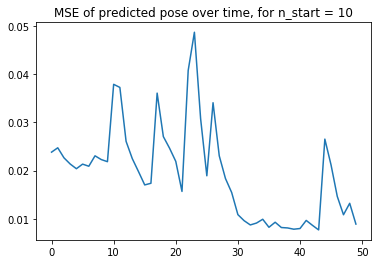

In [0]:
plt.plot(range(n_pred),MSE_time)
plt.title('MSE of predicted pose over time, for n_start = 10')

In [0]:
MSE = np.mean((long_target_obs[:,n_start:,:] - long_prediction[:,n_start:,:] )**2)
MSE

0.01949357261188715

In [0]:
#We know the future.. still in a training environment. 
#now predict poses recursively for the nex...
n_pred = 50
n_start = 50
short_target_obs = X_test[:10,n_start,:]
long_target_obs = X_test[:10,:n_start+n_pred,:]
long_prediction = np.zeros_like(X_test[:10,: n_start + n_pred, :])
#fill the prediction sequence with past observation up to starting point. 
long_prediction[:,:n_start,:] = X_test[:10,:n_start,:]

#h_test = past_ae_lstm.predict(past_obs)
#pred =vae.predict([future_obs,h_test[:,0,:]])
#past_obs = np.concat(past_obs,pred, axis=1) #append the last prediction as past observation

for t in np.arange(n_start,n_start+n_pred):
  past_obs = X_test[:10,:t,:]
  future_obs = X_test[:10,t:t+10,:]
  h_test = past_ae_lstm.predict(past_obs)
  pred =vae.predict([future_obs,h_test[:,0,:]])
  past_obs = np.concatenate([past_obs,pred.reshape(10,1,75)], axis=1)
  long_prediction[:,t,:] = pred

In [0]:
MSE_time = np.mean((long_target_obs[:,n_start:,:] - long_prediction[:,n_start:,:] )**2, axis=(0,-1))

In [0]:
np.mean((long_target_obs[:,n_start:,:] - long_prediction[:,n_start:,:] )**2)

0.008530360319874312

Text(0.5, 1.0, 'MSE of predicted pose over time, for n_start = 10')

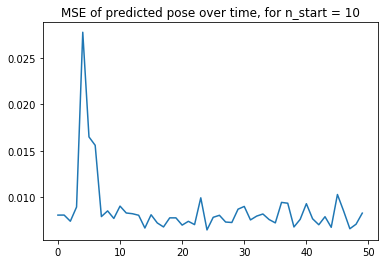

In [0]:
plt.plot(range(n_pred),MSE_time)
plt.title('MSE of predicted pose over time, for n_start = 10')

In [0]:
np.save(dataset_path+'future_target_10_test_nstart_50.npy',long_target_obs[:,n_start:,:])

In [0]:
np.save(dataset_path+'futre_pred_10_test_nstart_10.npy',long_prediction[:,n_start:,:])

In [0]:
#np.mean((long_target_obs[0,n_start:,:] - long_prediction[0,n_start:,:])**2,axis=(-1))

# Dropout Autoencoder - Pretrain

In [0]:
#https://bitbucket.org/parthaEth/humanposeprediction/src/ERD/python_models/EvaluateAutoEncoder/DropOutJointsExpt.py
def expandToAll3AxisIndices(index_list):
  #assuming the pose data is 25 x 3 not 3 x 25! 
    expanded_list = []
    for idx in index_list:
        for i in range(3):
            expanded_list.append((i*25)+idx)
    return expanded_list
  
  
def expandToAll3AxisIndices_old(index_list):
  #assuming the pose data is 25 x 3 not 3 x 25! 
    expanded_list = []
    for idx in index_list:
        for i in range(3):
            expanded_list.append((idx-1) * 3 + i)
    return expanded_list
  
  
def random_select_2D(batch_num,dropout_rate):
  joint_num = 25
  num_to_drop = int(dropout_rate*joint_num)
  index_array = np.random.randint(joint_num, size=(batch_num,num_to_drop))
  return index_array

def random_select(dropout_rate):
  joint_num = 25
  num_to_drop = int(dropout_rate*joint_num)
  index_array = np.random.randint(joint_num, size=(num_to_drop))
  return index_array

In [0]:
#Generates inputs for encoder: which is concat of future poses with past information. 
#Also generates target, which is a few poses in future. 
#Set to one step for now, while h_past is computed from t>10

class dae_generator(keras.utils.Sequence):

    def __init__(self,
                 train_data_dir=dataset_path + 'PKUMMD/X_train.npy',
                 valid_data_dir=dataset_path + 'PKUMMD/X_val.npy',
                 batch_size=128,
                 shuffle=True,
                 corrupt=True,
                 train = True,
                 dropout_rate = 0.5):

        self.train_data_dir = train_data_dir
        self.valid_data_dir = valid_data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train = train 
        self.data_list = self.load_data()
        self.on_epoch_end()
        self.corrupt = corrupt
        self.dropout_rate = dropout_rate #or create some sort of schedule... 
        
    def __len__(self):
        return int(len(self.data_list) / self.batch_size)

    def __getitem__(self, idx):

      data = self.data_list[idx * self.batch_size:(idx + 1) * self.batch_size] #load by batch.
      target = np.zeros((data.shape[0]* data.shape[1],data.shape[-1]))
      filtered = np.zeros((data.shape[0]* data.shape[1],data.shape[-1]))

      #loop by timestep, return each frame through time by batch. 
      for t in range(data.shape[1]):
        X_original = np.asarray(data[:,t,:], dtype=np.float32)

        #define a data generator
        index_array = random_select(self.dropout_rate) #or do an array... 
        dropout_idx = expandToAll3AxisIndices(index_array)
        X_filtered = np.array(X_original)

        ## drop by letting it be 0
        ## train by dropping the same joint per batch? 
        if self.corrupt:
          X_filtered[:,dropout_idx] = 0
        else:
          range_scale = 0.4
          X_filtered[:, dropout_idx] += np.random.uniform(low=-range_scale, high=range_scale,size=len(dropout_idx))

        #print('t=',t)
        target[t*self.batch_size:(t+1)*self.batch_size,:] = X_original 
        filtered[t*self.batch_size:(t+1)*self.batch_size,:] = X_filtered


        return filtered, target

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data_list)

    def load_data(self):
        if self.train:
          data_list = np.load(self.train_data_dir)
        else:
          data_list = np.load(self.valid_data_dir)
        #But instead, reshape such that each frame is one example!
        #data_list = data.reshape(data.shape[0]*data.shape[1], data.shape[-1])
        return data_list


In [0]:
class DAE(object):
  
    def __init__(self, hidden_dim = 256, #from past autoencoder
                elem_dim = 75,
                epochs = 8,
                lr = 0.001,
                 **kwargs):
    
        self.valid_data_dir = dataset_path + 'PKUMMD/X_train.npy'
        self.hidden_dim = hidden_dim
        self.elem_dim = elem_dim
        self.epochs = epochs
        self.lr = lr
        self.epochs = epochs
        self.build_model()

    def build_model(self):
        dropout_poses = Input(shape=(self.elem_dim,), name='dropout_poses')
        l1 = Dense(self.hidden_dim,activation='relu')(dropout_poses)
        #drop_l1 = tf.layers.dropout(inputs = l1,rate=0.2)
        #print('dropoute')
        l2 = Dense(self.hidden_dim,activation='relu')(l1)
        #drop_l2 = Dropout(rate=0.2)
        #drop_l2 = tf.layers.dropout(inputs = l2,rate=0.2)
        l3 = Dense(self.hidden_dim,activation='relu')(l2)
        #drop_l3 = tf.layers.dropout(inputs = l3,rate=0.2)
        recon_poses = Dense(self.elem_dim)(l3)
        self.model = Model(dropout_poses, recon_poses, name='dae')

    def train(self):
        params_train = {'shuffle': True,'train':True}
        params_val = {'shuffle': False,'train':False}
        self.model.compile(optimizer=optimizers.Adam(lr=self.lr),loss = losses.mean_squared_error) 
        self.model.fit_generator(generator=dae_generator(**params_train),epochs=self.epochs,validation_data=dae_generator(**params_val))


In [0]:
dae = DAE()
dae.train()

W0704 10:08:36.870774 139693775861632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/8
11/11 [==============================] - 5s 496ms/step - loss: 3.0087e-04 - val_loss: 1.0589e-04
Epoch 2/8
11/11 [==============================] - 1s 108ms/step - loss: 6.3946e-05 - val_loss: 2.2998e-05
Epoch 3/8
11/11 [==============================] - 1s 104ms/step - loss: 2.8846e-05 - val_loss: 2.1026e-05
Epoch 4/8
11/11 [==============================] - 1s 104ms/step - loss: 1.9725e-05 - val_loss: 1.7806e-05
Epoch 5/8
11/11 [==============================] - 1s 104ms/step - loss: 1.7160e-05 - val_loss: 2.2542e-05
Epoch 6/8
11/11 [==============================] - 1s 108ms/step - loss: 1.3789e-05 - val_loss: 1.3395e-05
Epoch 7/8
11/11 [==============================] - 1s 102ms/step - loss: 1.4956e-05 - val_loss: 1.0784e-05
Epoch 8/8
11/11 [==============================] - 1s 106ms/step - loss: 1.1169e-05 - val_loss: 1.1519e-05


In [0]:
from keras.models import load_model
#K.clear_session()
dae.model.save(dataset_path+'models/keras_dae_model.h5')  # creates a HDF5 file 'my_model.h5'

### unstructured

In [0]:
#trained seperately? on stationary poses? 
#article suggested three 3000-size dense layers!! with annealing dropout rate from 0.5
K.clear_session()
elem_dim = 75
hidden_dim = 500 
lr = 0.001
#original_poses = Input(shape=(elem_dim,), name='original_poses') #fixed time step ahead.

epochs = 5
dropout_rate = 0.2

dropout_poses = Input(shape=(elem_dim,), name='dropout_poses')
drop_l1 = Dense(hidden_dim,activation='relu')(dropout_poses)
drop_l2 = Dense(hidden_dim,activation='relu')(drop_l1)
drop_l3 = Dense(hidden_dim,activation='relu')(drop_l2)
recon_poses = Dense(elem_dim)(drop_l3)

dae = Model(dropout_poses, recon_poses, name='dae')
dae.compile(optimizer=optimizers.Adam(lr=lr),loss = losses.mean_squared_error) 
dae.fit_generator(generator=dae_generator(),epochs=epochs)#validation_data=(x_val, x_val)


Epoch 1/5
11/11 [==============================] - 2s 172ms/step - loss: 0.0087
Epoch 2/5
11/11 [==============================] - 2s 152ms/step - loss: 0.0014
Epoch 3/5
11/11 [==============================] - 2s 155ms/step - loss: 7.9368e-04
Epoch 4/5
11/11 [==============================] - 2s 154ms/step - loss: 5.0673e-04
Epoch 5/5
11/11 [==============================] - 2s 155ms/step - loss: 3.9211e-04


# Future VAE LSTM - Not done

# Future VQ-VAE - Not done